# Testing: Three layer GRU coders
**Version 13c**:
- Word level tokens
- GRU type RNNs
- 'sparse_categorical_crossentropy' to save memory
- dropout to hinder overfitting
- using large dataset
- Two layer GRU encoder **new in this model**

**Reference, best result so far:**
- Model 13b after 65 epochs, 650 minutes: loss: 1.3777 - val_loss: 1.2907

**Conclusions:**
- Inference decoder not made yet!
- Batch size makes a difference on loss, 512 seems to be too big on the small data set

**Improvments to be implemented:**
- clean-up code around the internal states, lots of confusion around "[]"
- Larger latent_dim (=512?)
- randomize input data?
- try / understand 'TimeDistributed': decoder_dense = TimeDistributed(Dense(Y_lstm.shape[2], activation = 'relu'))
- dropout as layer
- L2 reg
- deeper models to represent more complex sentences, more RNN layers?
- bi-directional layers: https://stackoverflow.com/questions/50815354/seq2seq-bidirectional-encoder-decoder-in-keras
- model.fit_generator to handle larger datasets
- attention 
- Gradient clipping is important for RNNs training (clipvalue=1.0), book page 309
- test: metrics=['accuracy']
- set 'return_sequences' or 'return_stage' to false in models? Something is rotten
- **Done** Smaller batch size, eg 32 vs 512 may give a getter val_loss? Proved to be that way with the chatbot!
- **Done** test Pandas dataframe for nice outputs (https://www.tutorialspoint.com/python_pandas/python_pandas_dataframe.htm)
- **Done** dropout in RNN layer:
- **Done** Simplify by suing GRU RNN
- **Done** ' to_categorical' as one-hot encoder, makes huge matrices
- **Done** "sparse_categorical_crossentropy" to reduce the 'one hot' tensor
- **Done** operates right now with long sentences: 8*std_div, shound be less when longer sentences are trained
- **Done** train on larger dataset
- **Done** something is wrong with the index of the one-hot; the model allows to return "0" as the best index, but the token2word starts from "1". It seems to be OK

**Credits to many fine people on the internet:**
- https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
- https://medium.com/@dev.elect.iitd/neural-machine-translation-using-word-level-seq2seq-model-47538cba8cd7
- https://stackoverflow.com/questions/49477097/keras-seq2seq-word-embedding
- https://github.com/devm2024/nmt_keras/blob/master/base.ipynb
- https://www.kaggle.com/ievgenvp/lstm-encoder-decoder-via-keras-lb-0-5
- https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/21_Machine_Translation.ipynb

In [1]:
import os
import tensorflow as tf
import numpy as np

from keras.models import Model
from keras.layers import Input, Embedding, LSTM, GRU, Dense
from tensorflow.python.keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

C:\Users\ThomasGordon\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
tf.__version__

'1.5.0'

In [3]:
tf.keras.__version__

'2.1.2-tf'

In [4]:
# global variables

num_samples = 100000       # Number of samples to train on
num_words = 10000          # Limit vocabulary in translation
latent_dim = 256           # Latent dimensionality of the encoding space

batch_size = 32            # Batch size for training.
numEpochs = 100            # Number of epochs to train for.
DropOut = 0.3              # Used in GRU layers

dataSetSize = 14839        # small dataset = 14839, all data = 9999999

truncate_std_div = 2       # truncate sentences after x tokens, 2 standard deviations = 95% included
mark_start = 'ssss '       # start and end markes for destination sentences
mark_end = ' eeee'

### Read training data into tables
the result is two tables with the input and output texts:input_texts[] and output_texts[]. Output texts are enriched bed adding the start and end markers. I join sentences from two datasets to get a larger and more diverse training set

In [5]:
# Read data into tables, first data set
input_texts_a = []
target_texts_a = []

with open('dan-eng/dan.txt', 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

for line in lines[: min(num_samples, len(lines) - 1)]:
    target_sentence, input_sentence = line.split('\t')                   # reversed to get DA --> EN
    target_sentence = mark_start + target_sentence.strip() + mark_end
    input_texts_a.append(input_sentence)
    target_texts_a.append(target_sentence)

# Examples
print('Size of small dataset: ', len(input_texts_a))
print(input_texts_a[15:20])
print(target_texts_a[15:20])

Size of small dataset:  14839
['Aldrig i livet!', 'Ikke tale om!', 'Absolut ikke!', 'Under ingen omstændigheder!', 'Aldrig i verden!']
['ssss No way! eeee', 'ssss No way! eeee', 'ssss No way! eeee', 'ssss No way! eeee', 'ssss No way! eeee']


In [6]:
input_texts = []
target_texts = []

In [7]:
# source into a table, the second and larger dataset
filename = "europarl-v7.da-en.da"
data_dir = "data/europarl/"
path = os.path.join(data_dir, filename)
with open(path, encoding="utf-8") as file:
    # Read the line from file, strip leading and trailing whitespace,
    # prepend the start-text and append the end-text.
    input_texts = [line.strip() for line in file]

In [8]:
# destination into a table, the second and larger dataset
filename = "europarl-v7.da-en.en"
path = os.path.join(data_dir, filename)
with open(path, encoding="utf-8") as file:
    # Read the line from file, strip leading and trailing whitespace,
    # prepend the start-text and append the end-text.
    target_texts = [mark_start + line.strip() + mark_end for line in file]

In [9]:
print('Size of large dataset: ', len(input_texts))
i = 2
print(input_texts[i])
print(target_texts[i])

Size of large dataset:  1968800
Som De kan se, indfandt det store "år 2000-problem" sig ikke. Til gengæld har borgerne i en del af medlemslandene været ramt af meget forfærdelige naturkatastrofer.
ssss Although, as you will have seen, the dreaded 'millennium bug' failed to materialise, still the people in a number of countries suffered a series of natural disasters that truly were dreadful. eeee


In [10]:
# join the two data set to one big, gives me both short and long sentences
input_texts = input_texts_a + input_texts
target_texts = target_texts_a + target_texts
print('Size of small+large dataset: ', len(input_texts))

Size of small+large dataset:  1983639


In [11]:
print
print('Original dataset size:   ', len(input_texts), len(target_texts))
input_texts = input_texts[:dataSetSize]
target_texts = target_texts[:dataSetSize]
print('New lighter dataset size:', len(input_texts), len(target_texts))

Original dataset size:    1983639 1983639
New lighter dataset size: 14839 14839


In [12]:
# testing Pandas
import pandas as pd
pd.set_option('display.max_colwidth', -1)
df = pd.DataFrame({'Source texts':input_texts, 'Target texts':target_texts})
df.sample(10)

,Source texts,Target texts
12112,De behøver ikke at gå i skole i dag.,ssss They don't have to go to school today. eeee
6079,Kan I huske Tom?,ssss Do you guys remember Tom? eeee
9051,Kurven var fuld af æbler.,ssss The basket was full of apples. eeee
3747,Han har skrevet et brev til mig.,ssss He wrote me a letter. eeee
10312,Jeg har lidt penge i denne måned.,ssss I have a little money this month. eeee
2438,Du er en god mand.,ssss You're a good man. eeee
11148,Jeg takker jer på forhånd for jeres hjælp.,ssss Thank you in advance for your help. eeee
6690,Han blev dømt til døden.,ssss He was sentenced to death. eeee
3289,Jeg er ikke din far.,ssss I'm not your father. eeee
10364,I femten år har jeg været lærer.,ssss I've been a teacher for 15 years. eeee


### Tokenize input sentences

In [13]:
# index to be used as demo
idx = 1000

# crate input tokenizer and create vocabulary from the texts
tokenizer_inp = Tokenizer(num_words=num_words)
tokenizer_inp.fit_on_texts(input_texts)
print('Found %s unique source tokens.' % len(tokenizer_inp.word_index))

# translate from word sentences to token sentences
tokens_inp = tokenizer_inp.texts_to_sequences(input_texts)

# Shorten the longest token sentences, Find the length of all sentences, truncate after x * std deviations
num_tokens = [len(x) for x in tokens_inp]
print('Longest sentence is %s tokens.' % max(num_tokens))
max_tokens_input = np.mean(num_tokens) + truncate_std_div * np.std(num_tokens)
max_tokens_input = min(int(max_tokens_input), max(num_tokens))
print('Sentences shortened to max %s tokens.' % max_tokens_input)

# Pad / truncate all token-sequences to the given length
tokens_padded_input = pad_sequences(tokens_inp,
                                    maxlen=max_tokens_input,
                                    padding='post',
                                    truncating='post')
print('Shape of input tokens:', tokens_padded_input.shape)
print('Input example: ', tokens_padded_input[idx])

# Create inverse lookup from integer-tokens to words
index_to_word_input = dict(zip(tokenizer_inp.word_index.values(), tokenizer_inp.word_index.keys()))

# function to return readable text from tokens string
def tokens_to_string_inp(tokens):
    words = [index_to_word_input[token] 
            for token in tokens
            if token != 0]
    text = " ".join(words)
    return text

# demo to show that it works
print(tokens_to_string_inp(tokens_padded_input[idx]))
print(input_texts[idx])
print(tokens_padded_input[idx])

Found 7068 unique source tokens.
Longest sentence is 27 tokens.
Sentences shortened to max 10 tokens.
Shape of input tokens: (14839, 10)
Input example:  [ 31 135   7   0   0   0   0   0   0   0]
de købte det
De købte det.
[ 31 135   7   0   0   0   0   0   0   0]


### Tokenize destination sentences

In [14]:
# index to be used as demo
idx = 1000

# crate input tokenizer and create vocabulary from the texts
tokenizer_target = Tokenizer(num_words=num_words)
tokenizer_target.fit_on_texts(target_texts)
print('Found %s unique target tokens.' % len(tokenizer_target.word_index))

# translate from word sentences to token sentences
tokens_target = tokenizer_target.texts_to_sequences(target_texts)

# translate from word sentences to token sentences
tokens_target = tokenizer_target.texts_to_sequences(target_texts)

# Shorten the longest token sentences, Find the length of all sentences, truncate after x * std deviations
num_tokens = [len(x) for x in tokens_target]
print('Longest sentence is %s tokens.' % max(num_tokens))
max_tokens_target = np.mean(num_tokens) + truncate_std_div * np.std(num_tokens)
max_tokens_target = min(int(max_tokens_target), max(num_tokens))
print('Sentences shortened to max %s tokens.' % max_tokens_target)

# Pad / truncate all token-sequences to the given length
tokens_padded_target = pad_sequences(tokens_target,
                                     maxlen=max_tokens_target,
                                     padding='post',
                                    truncating='post')
print('Shape of target tokens:', tokens_padded_target.shape)
print('Target example: ', tokens_padded_target[idx])

# Create inverse lookup from integer-tokens to words
index_to_word_target = dict(zip(tokenizer_target.word_index.values(), tokenizer_target.word_index.keys()))

# function to return readable text from tokens string
def tokens_to_string_target(tokens):
    words = [index_to_word_target[token] 
            for token in tokens
            if token != 0]
    text = " ".join(words)
    return text

# demo to show that it works
print(tokens_to_string_target(tokens_padded_input[idx]))
print(target_texts[idx])
print(tokens_padded_target[idx])

Found 5295 unique target tokens.
Longest sentence is 26 tokens.
Sentences shortened to max 12 tokens.
Shape of target tokens: (14839, 12)
Target example:  [  1  49 116  14   2   0   0   0   0   0   0   0]
not school tom
ssss They bought it. eeee
[  1  49 116  14   2   0   0   0   0   0   0   0]


In [15]:
# start and end marks as tokens, needed when translating
token_start = tokenizer_target.word_index[mark_start.strip()]
token_end = tokenizer_target.word_index[mark_end.strip()]
print(token_start, token_end)

1 2


### Traing data
- Input to the encoder is simply the source language as it is
- Inputs to the decoder are slightly more complicated, since the two input strings are shiften one time-step: The model has to learn to predict the "next" token in the output from the input. Slizing is used to get two "views" to the data

In [16]:
encoder_input_data = tokens_padded_input
encoder_input_data.shape

(14839, 10)

In [17]:
decoder_input_data = tokens_padded_target[:, :-1]
decoder_input_data.shape

(14839, 11)

In [18]:
decoder_target_data = tokens_padded_target[:, 1:]
decoder_target_data.shape

(14839, 11)

Examples showing the training data to the model

In [19]:
encoder_input_data[idx]

array([ 31, 135,   7,   0,   0,   0,   0,   0,   0,   0])

In [20]:
decoder_input_data[idx]

array([  1,  49, 116,  14,   2,   0,   0,   0,   0,   0,   0])

In [21]:
decoder_target_data[idx]

array([ 49, 116,  14,   2,   0,   0,   0,   0,   0,   0,   0])

### Create training model

In [22]:
# GRU encoder elements
encoder_inputs = Input(shape=(None,), name='encoder_input')
encoder_embed = Embedding(num_words, latent_dim, name='encoder_embedding')
encoder_GRU1 = GRU(latent_dim, 
                   dropout=DropOut, 
                   recurrent_dropout=DropOut, 
                   return_sequences=True, 
                   name='encoder_gru1')
encoder_GRU2 = GRU(latent_dim, 
                   dropout=DropOut, 
                   recurrent_dropout=DropOut, 
                   return_sequences=True, 
                   name='encoder_gru2')
encoder_GRU3 = GRU(latent_dim, 
                   dropout=DropOut, 
                   recurrent_dropout=DropOut, 
                   return_state=True, 
                   name='encoder_gru3')

# connect encoder
net = encoder_inputs
net = encoder_embed(net)
net = encoder_GRU1(net)
net = encoder_GRU2(net)
net = encoder_GRU3(net)

# outputs of encoder, from last GRU layer
encoder_outputs, state_h = net

In [23]:
# GRU decoder elements, using `state_h` (encoder hidden states) as initial state
decoder_inputs = Input(shape=(None,), name='decoder_input')
decoder_embed =  Embedding(num_words, latent_dim, name='decoder_embedding')
decoder_gru1 =   GRU(latent_dim, 
                     dropout=DropOut, recurrent_dropout=DropOut, 
                     return_sequences=True, 
                     return_state=False, 
                     name='decoder_gru1')    
decoder_gru2 =   GRU(latent_dim, 
                     dropout=DropOut, recurrent_dropout=DropOut, 
                     return_sequences=True, 
                     return_state=False, 
                     name='decoder_gru2')    
decoder_gru3 =   GRU(latent_dim, 
                     dropout=DropOut, recurrent_dropout=DropOut, 
                     return_sequences=True, 
                     return_state=True, 
                     name='decoder_gru3')    
decoder_dense =  Dense(num_words, activation='linear', name='decoder_output')

# connect decoder
net = decoder_inputs
net = decoder_embed(net)
net = decoder_gru1(net, initial_state=state_h)
net = decoder_gru2(net, initial_state=state_h)
net = decoder_gru3(net, initial_state=state_h)

# connect dense layer to GRUs
decoder_outputs, dec_states_h = net
decoder_outputs = decoder_dense(decoder_outputs)

# define decoder model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
encoder_embedding (Embedding)   (None, None, 256)    2560000     encoder_input[0][0]              
__________________________________________________________________________________________________
encoder_gru1 (GRU)              (None, None, 256)    393984      encoder_embedding[0][0]          
__________________________________________________________________________________________________
decoder_input (InputLayer)      (None, None)         0                                            
__________________________________________________________________________________________________
encoder_gr

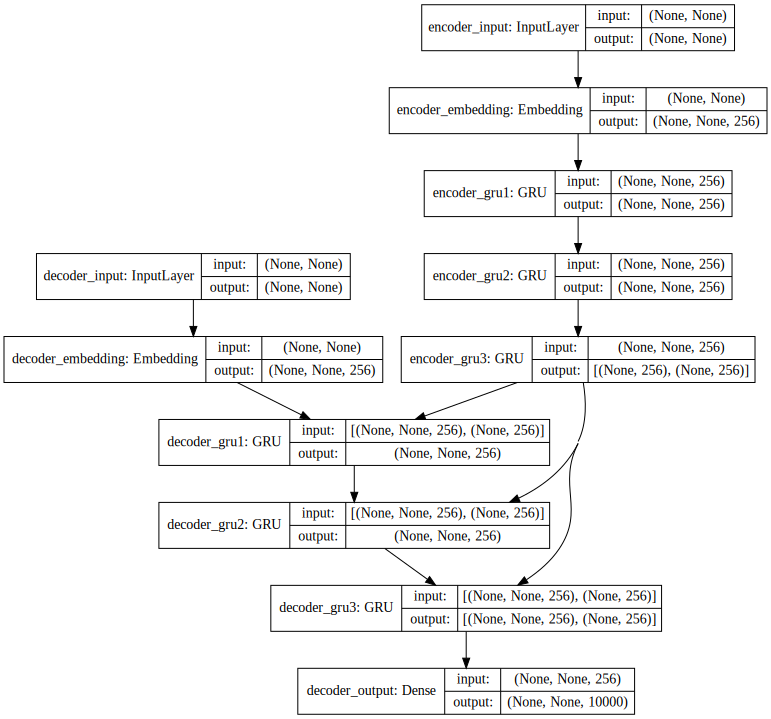

In [24]:
# visualise model as a graph
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import pydot_ng as pydot
import graphviz as graphviz
SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

### Train the model

In [25]:
# custom loss function since sparse does not work: https://github.com/tensorflow/tensorflow/issues/17150
def sparse_cross_entropy(y_true, y_pred):
    # Calculate the loss. This outputs a 2-rank tensor of shape [batch_size, sequence_length]
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred)
    loss_mean = tf.reduce_mean(loss)
    return loss_mean

In [26]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

In [27]:
model.compile(optimizer='rmsprop',
              loss=sparse_cross_entropy,
              target_tensors=[decoder_target])

In [28]:
# call backs to stop model when it does not improve more
path_checkpoint = 'tgc_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

callback_early_stopping = EarlyStopping(monitor='val_loss', 
                                        patience=3, 
                                        verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint]

In [ ]:
# Note that `decoder_target_data` needs to be one-hot encoded,
# rather than sequences of integers like `decoder_input_data`!
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
                    batch_size=batch_size,
                    epochs=numEpochs,
                    validation_split=0.2,
                    callbacks=callbacks)
model.save('TGC_trans.h5')

In [ ]:
history_dict = history.history
history_dict.keys()

In [ ]:
import matplotlib.pyplot as plt
plt.show()

In [ ]:
# plotter historikken for 'loss'
loss     = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'bo', label='Training loss')       # bo = "blue dot"
plt.plot(epochs, val_loss, 'b', label='Validation loss')  # b  = "solid blue line"
plt.title('Training and validation loss')
plt.legend()
plt.show()

## Inference mode = testing the model

### create sampling model

In [ ]:
# encoder model used to create internal representation / states
encoder_model = Model(encoder_inputs, state_h)
encoder_model.summary()

In [ ]:
# visualise encoder model as a graph
SVG(model_to_dot(encoder_model,show_shapes=True).create(prog='dot', format='svg'))

In [30]:
#################################
'''her skal bruges en ny initial state h'''


decoder_initial_state = Input(shape=(latent_dim,),
                              name='decoder_initial_state')



decoder_state_input_h = Input(shape=(latent_dim,))

# connect decoder
net2 = decoder_inputs
net2 = decoder_embed(net2)
net2 = decoder_gru1(net2, initial_state=decoder_initial_state)
net2 = decoder_gru2(net2, initial_state=decoder_initial_state)
net2 = decoder_gru3(net2, initial_state=decoder_initial_state)

# connect dense layer to GRUs
decoder_outputs, dec_states_h = net
decoder_outputs = decoder_dense(decoder_outputs)




decoder_model = Model([decoder_inputs]+[decoder_state_input_h], 
                      [decoder_outputs]+[state_h])               # notice the '+' operator requires [] to work


RuntimeError: Graph disconnected: cannot obtain value for tensor Tensor("encoder_input:0", shape=(?, ?), dtype=float32) at layer "encoder_input". The following previous layers were accessed without issue: []

In [ ]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_inputs = [decoder_state_input_h,]

# reuse the decoder we have trained
decoder_embed_final2 = decoder_embed(decoder_inputs)

decoder_outputs2, state_h2 = decoder_gru1(decoder_embed_final2, initial_state=decoder_state_inputs)

decoder_outputs2 = decoder_dense(decoder_outputs2)

decoder_model = Model(
    [decoder_inputs] + decoder_state_inputs, 
    [decoder_outputs2] + [state_h2])                    # notice the '+' operator requires [] to work !!!

decoder_model.summary()

In [ ]:
# visualise decoder model as a graph
SVG(model_to_dot(decoder_model,show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
def decode_sequence(input_seq):
   
    # tokenize the text to be translated, and reverse
    input_tokens = tokenizer_inp.texts_to_sequences([input_seq])
    input_tokens = pad_sequences(input_tokens,
                                 maxlen=max_tokens_input,
                                 padding='post',
                                 truncating='post')

    # encode the input sentence
    states_value = encoder_model.predict(input_tokens)
    
    # Generate empty target sequence of length 1 and insert start token
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = token_start    #

    # sampling loop to generate translated words using decoder, word by word
    stop_condition = False
    decoded_sentence = ''
    
    while not stop_condition:  
        # predict one next word, decoder returns probabilities for all words/tokens
        output_tokens, h = decoder_model.predict([target_seq] + [states_value])
        
        # pick most probable token / word
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = index_to_word_target[sampled_token_index]
        decoded_sentence += ' '+sampled_word
        
        # Exit condition: either hit max length or find stop character.
        if (sampled_word == 'eeee' or len(decoded_sentence) > 52):
            stop_condition = True
        
        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index
        
        # Update states, so they can be re-injected in next token/word prediction
        states_value = h

    return decoded_sentence

### Doing translation ...

In [ ]:
# testing on known sentences from training data
for idx in range(1000, 1010):
    input_seq = input_texts[idx]
    decoded_sentence = decode_sequence(input_seq)
    print(input_seq, '\n ==> ', decoded_sentence, '\n\n')

In [ ]:
# testing on unknown sentences from validation data
for idx in range(12000, 12010):
    input_seq = input_texts[idx]
    decoded_sentence = decode_sequence(input_seq)
    print(input_seq, '\n ==> ', decoded_sentence, '\n\n')

In [ ]:
input_seq = 'vi ses'
decoded_sentence = decode_sequence(input_seq)
print(input_seq, '\n ==> ', decoded_sentence, '\n\n')

In [ ]:
input_seq = 'gå nu'
decoded_sentence = decode_sequence(input_seq)
print(input_seq, '\n ==> ', decoded_sentence, '\n\n')